In [20]:
# Import dependencies
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam

import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')

In [8]:
# Initial retrival
def get_data(path):
    generator = ImageDataGenerator(rescale=1.0/255.)
    dataset = generator.flow_from_directory(
        directory=path,
        target_size=IMG_SHAPE,
        color_mode='rgb',
        class_mode='sparse',
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2},
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )
    return dataset

In [9]:
# Image generator params
TRAIN_PATH = "covid19-resources/train"
TEST_PATH = "covid19-resources/test"
IMG_SHAPE = [224, 224]
BATCH_SIZE = 32

In [10]:
training_data = get_data(TRAIN_PATH)

kaggle datasets download -d pranavraikokte/covid19-image-dataset

Found 251 images belonging to 3 classes.


In [11]:
# Preview images
def preview_data(data):
    features = data[0][0]
    labels = data[0][1]
    fig, ax = plt.subplots(figsize=(20,20), ncols=4, nrows=4)
    for i, a in enumerate(ax.flatten()):
        a.imshow(features[i])
        a.set_title("Normal" if labels[i] == 0 else "Viral Pneumonia" if labels[i] == 1 else "Covid")
    fig.suptitle("")

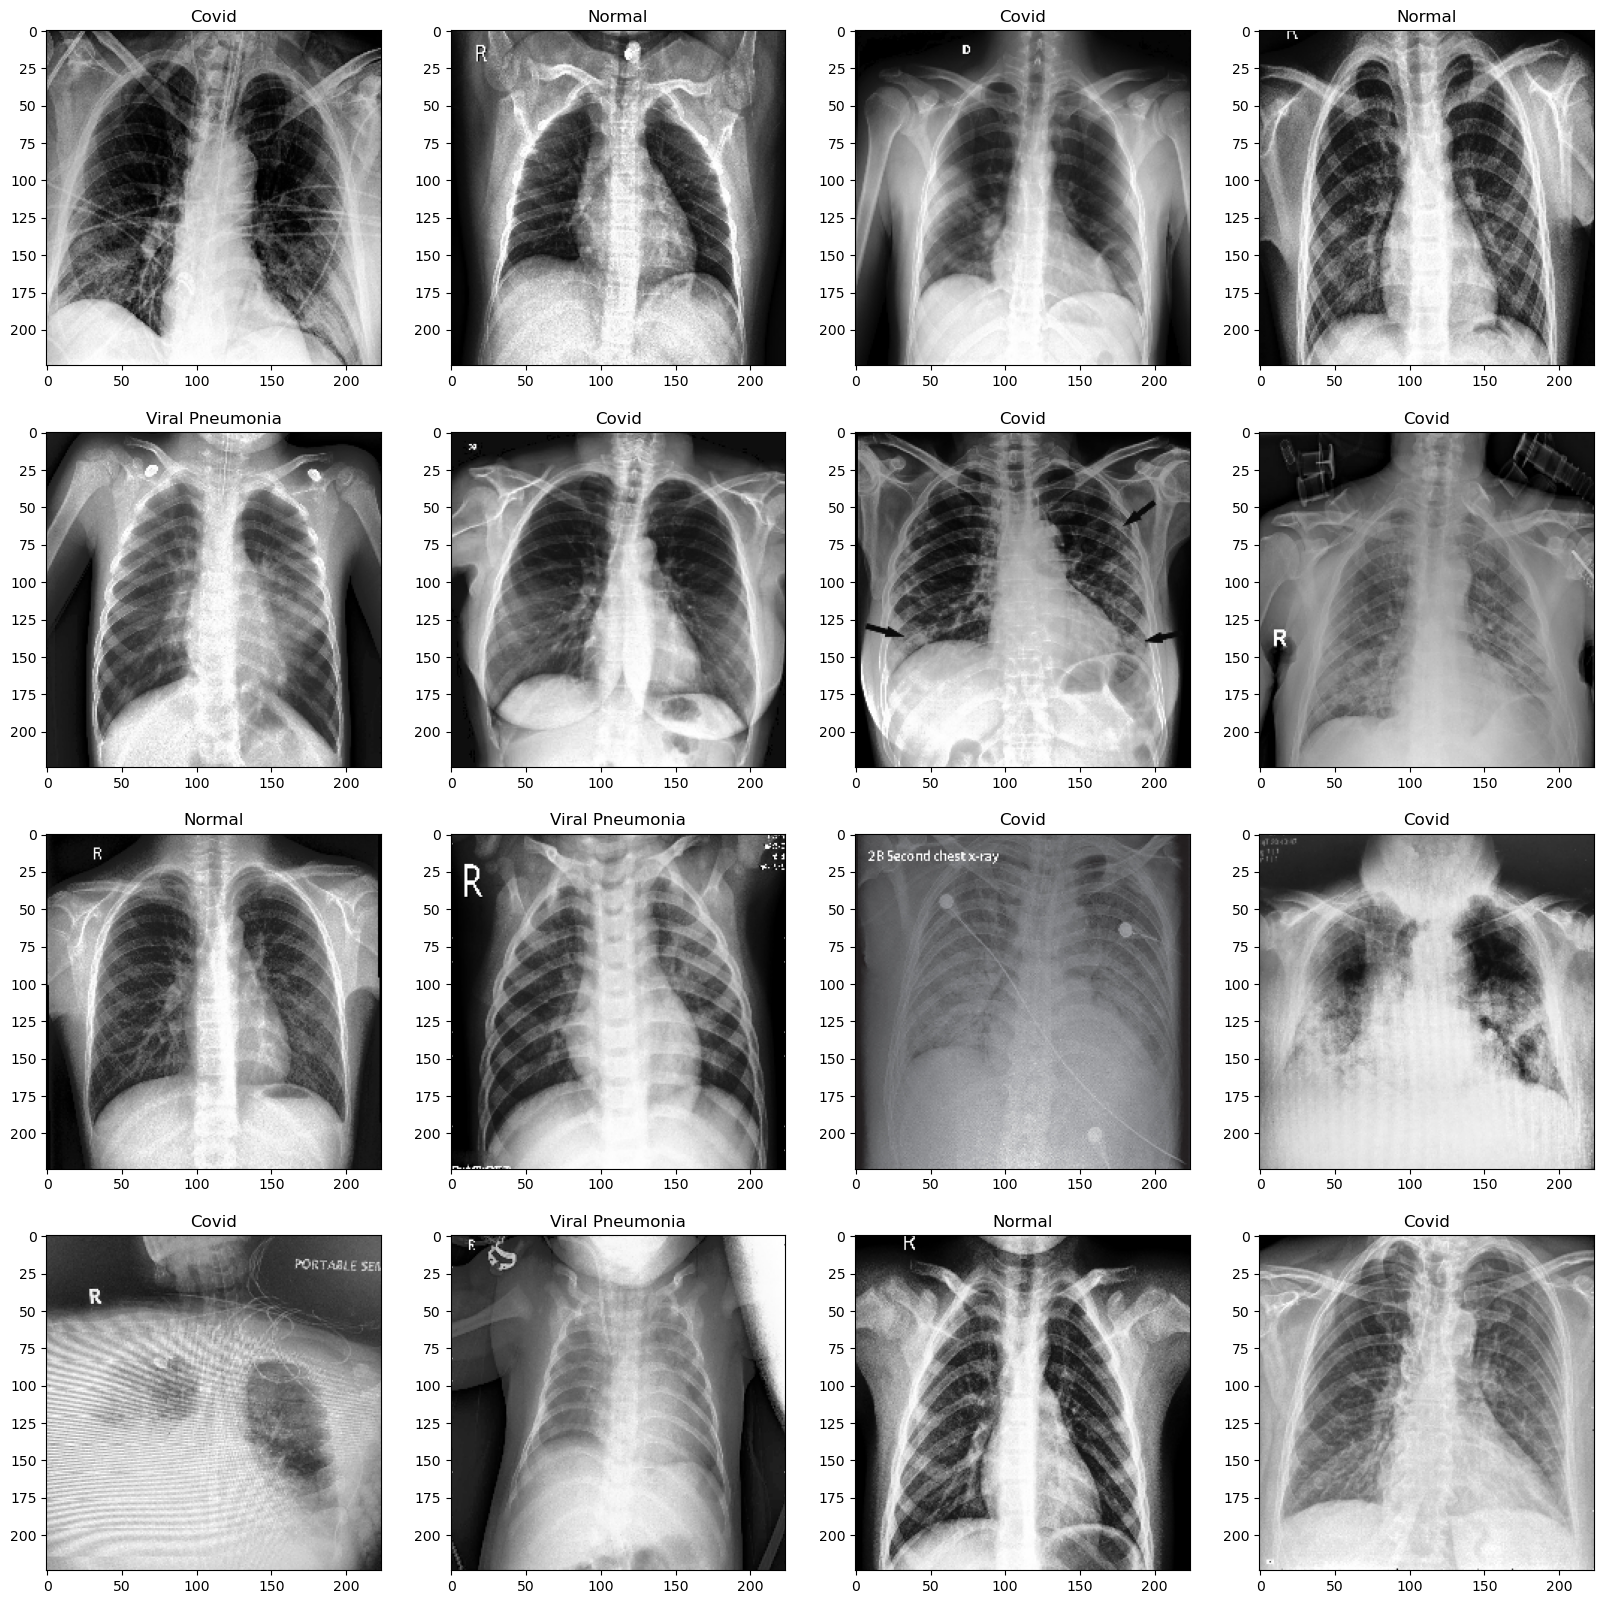

In [12]:
preview_data(training_data)

In [13]:
# Augment data to accommodate body angles, body size, etc.
def get_augmented_data(path):
    generator = ImageDataGenerator(rescale=1.0/255.,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.15,
        horizontal_flip=True,
    )
    dataset = generator.flow_from_directory(
        directory=path,
        target_size=IMG_SHAPE,
        color_mode='rgb',
        class_mode='sparse',
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2},
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )
    return dataset

In [14]:
training_data = get_augmented_data(TRAIN_PATH)
testing_data = get_augmented_data(TEST_PATH)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


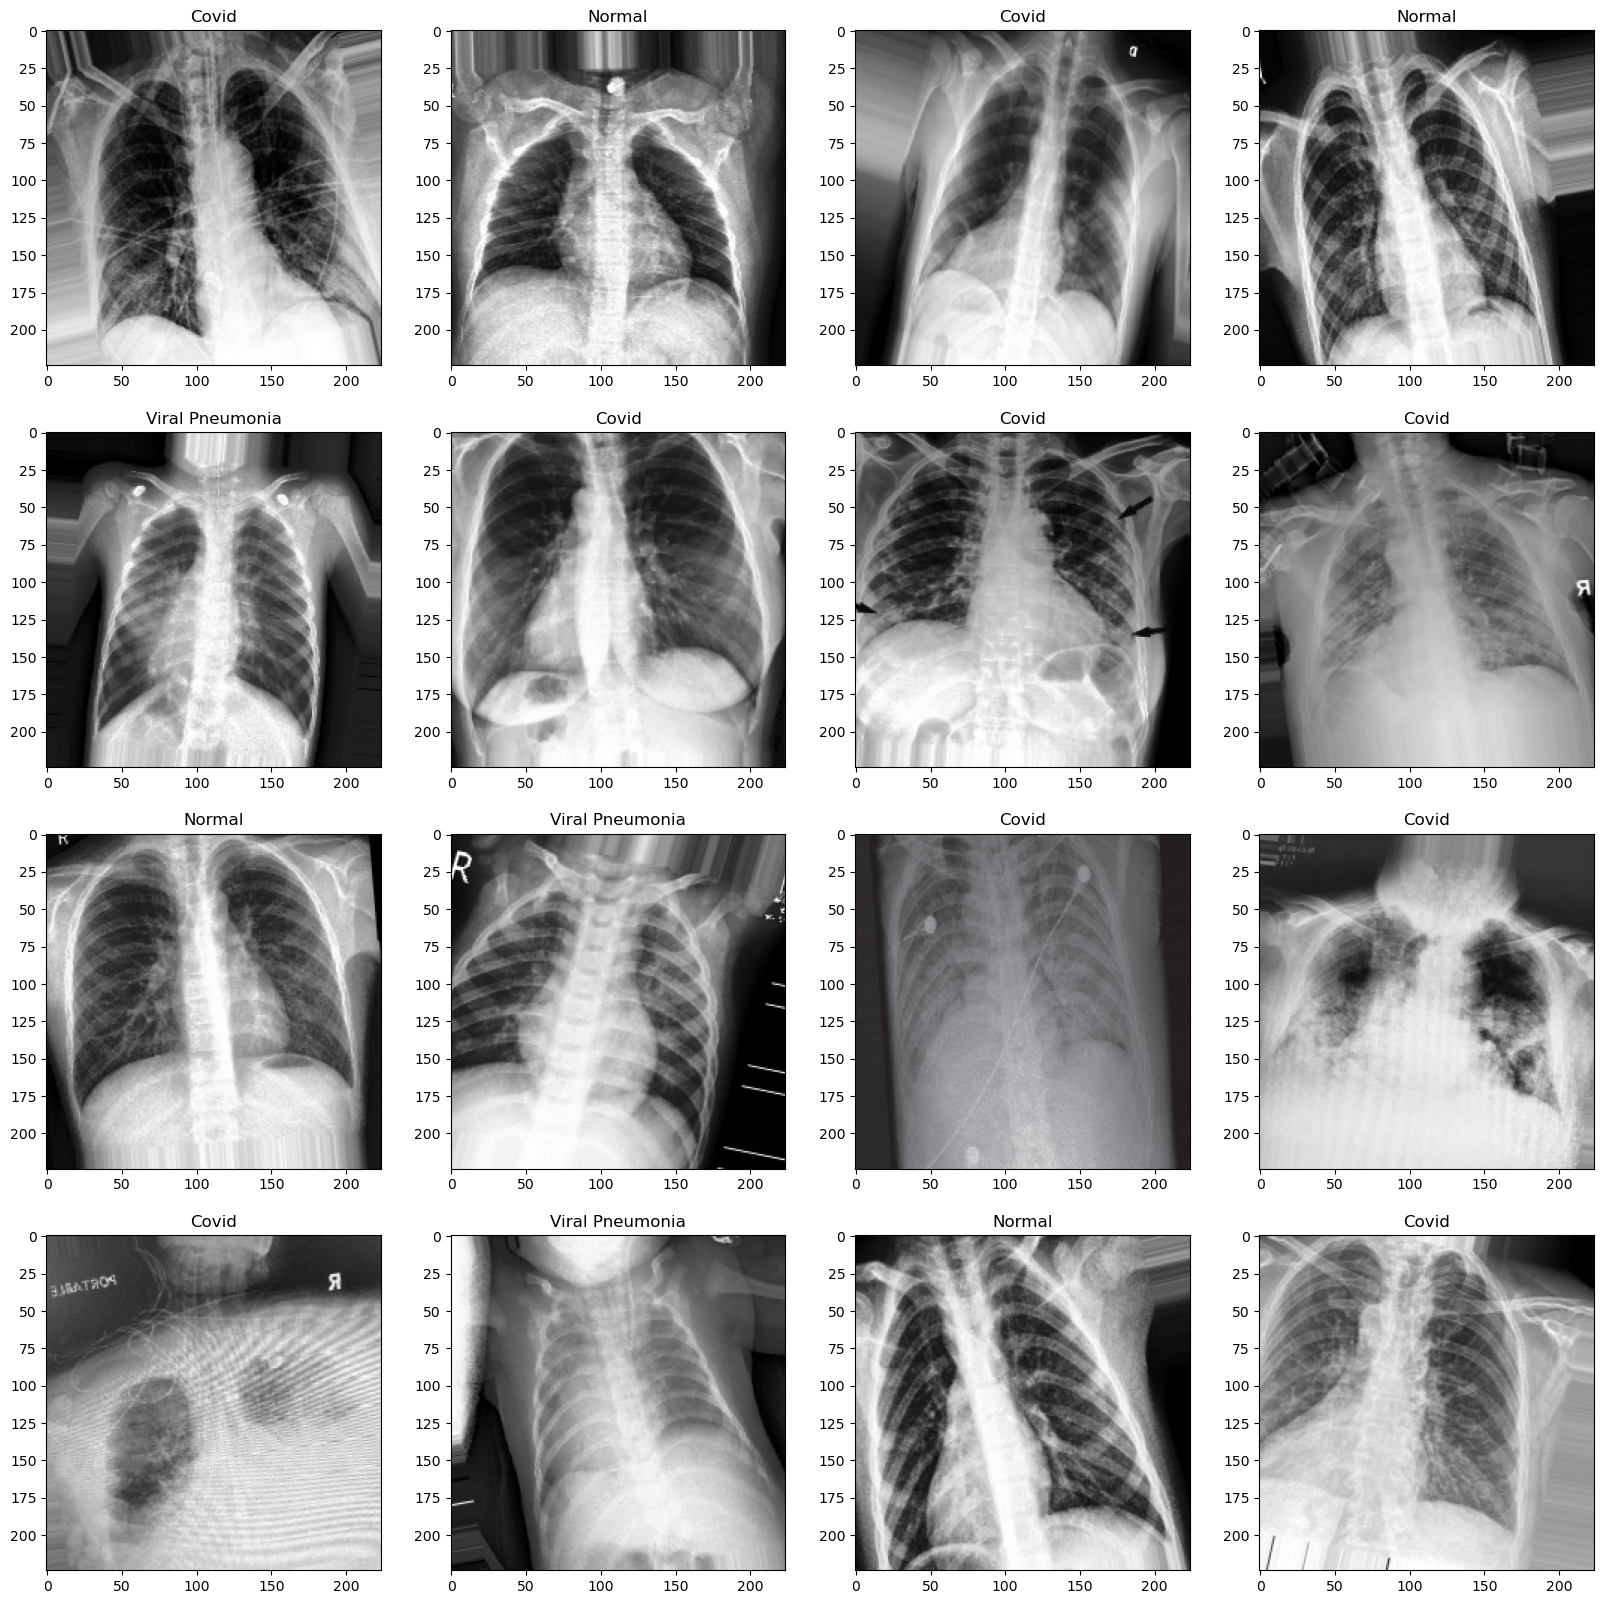

In [15]:
preview_data(training_data)

In [22]:
# Build model
early_callback = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience=5)
checkpoint_callback = ModelCheckpoint('model/vgg16_best.h5', 
                                      monitor='accuracy', 
                                      mode='max',
                                      save_best_only=True)
optimizer = Adam(learning_rate=0.001)

def build_model_one(base_model):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
    model.add(base_model)
    model.add(GlobalMaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3,activation="softmax"))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def fit_model(md, x_train, x_valid, e):
    callback = [early_callback, checkpoint_callback]
    history = md.fit(x_train, validation_data=x_valid, epochs=e, callbacks=[callback])
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label='validation accuracy')
    ax[0].set_title("Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(loc='best')
    ax[1].plot(history.history['loss'], label='training_loss')
    ax[1].plot(history.history['val_loss'], label='validation loss')
    ax[1].set_title("Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend(loc='best')
    fig.savefig('Images/model-performance/model2-cnn-vgg16.png')
    return history

In [23]:
# Model Summary
base = VGG16(weights='imagenet',
             include_top=False,
             input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)
             )
model = build_model_one(base)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [25]:
# Model testing
fit_model(model, training_data, testing_data, e=40)

Epoch 1/40
8/8 [==============================] - 55s 7s/step - loss: 0.9514 - accuracy: 0.5458 - val_loss: 0.8797 - val_accuracy: 0.6515
Epoch 2/40
8/8 [==============================] - 55s 7s/step - loss: 0.8275 - accuracy: 0.6215 - val_loss: 0.7001 - val_accuracy: 0.6818
Epoch 3/40
8/8 [==============================] - 54s 7s/step - loss: 0.8401 - accuracy: 0.6215 - val_loss: 0.6757 - val_accuracy: 0.6212
Epoch 4/40
8/8 [==============================] - 55s 7s/step - loss: 0.7333 - accuracy: 0.6653 - val_loss: 0.6496 - val_accuracy: 0.7121
Epoch 5/40
8/8 [==============================] - 55s 7s/step - loss: 0.7102 - accuracy: 0.6414 - val_loss: 0.5998 - val_accuracy: 0.7424
Epoch 6/40
8/8 [==============================] - 55s 7s/step - loss: 0.6605 - accuracy: 0.6813 - val_loss: 0.6225 - val_accuracy: 0.6364
Epoch 7/40
8/8 [==============================] - 55s 7s/step - loss: 0.7480 - accuracy: 0.6414 - val_loss: 0.9121 - val_accuracy: 0.7273
Epoch 8/40
8/8 [==================

KeyboardInterrupt: 